#GitAnalysis using Theano

In [1]:
%matplotlib inline

In [2]:
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings
import copy
import pickle

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import sys
sys.path.append('../dev')

from ml_plot import plot_validation_curve
from ml_plot import my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions
from ml_plot import PredictCV, PredictCV_TrainTest
from ml_plot import PredictCV_TrainTestValidate

In [3]:
from Theano_NN import test_nn, modern_nn_model, modern_nn_model_h1
from Theano_NN import convert_binary_to_onehot, compute_stats, print_stats

In [4]:
PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
# PROJECT = 'heat'
PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
# SCORING = 'roc_auc'

JOBS = 4
VERBOSE = True

warnings.filterwarnings('ignore', 'F-score is ill-defined')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

#Function definitions

In [5]:
def print_stats2(metric_name, metric_value, param_name, param_value, stats):
    print 'Best Results for {0} : {1}  {2} : {3}'.format(
        metric_name, metric_value, param_name, param_value)
    print '    {0:8} {1:8}'.format(stats['TP'], stats['FP'])
    print '    {0:8} {1:8}'.format(stats['FN'], stats['TN'])
    print '    Precision: {0:0.2f} Recall: {1:0.2f}, F1: {2:0.2f}'.format(
        stats['precision'], stats['recall'], stats['f1'])    

In [6]:
def analyze_bias(predict, X_test, Y_test, min_bias=-0.2, max_bias=0.05, test_points=10, detail=False):
    best_f1 = 0.0
    best_f1_bias = 0.0
    best_f1_stats = []
    best_precision = 0.0
    best_precision_bias = 0.0
    best_precision_stats = []
    for bias in np.linspace(min_bias, max_bias, test_points):
        biasV = np.array([-bias, bias])
    
        y_predict = predict(X_test, bias=biasV)
        y_target = np.argmax(Y_test, axis=1)
            
        (cost, TP, FP, FN, TN, precision, recall, f1) = compute_stats(y_predict, y_target)
        if detail:
            print 'Bias:', bias
            print_stats(0, cost, TP, FP, FN, TN, precision, recall, f1)
            print
        if f1 > best_f1:
            best_f1 = f1
            best_f1_bias = bias
            best_f1_stats = {'cost':cost, 'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN,
                             'precision':precision, 'recall':recall, 'f1':f1}
        if precision > best_precision:
            best_precision = precision
            best_precision_bias = bias
            best_precision_stats = {'cost':cost, 'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN, 
                                    'precision':precision, 'recall':recall, 'f1':f1}
        
    print_stats2('F1', best_f1, 'Bias', best_f1_bias, best_f1_stats)
    print
    print_stats2('Precision', best_precision, 'Bias', best_precision_bias, best_precision_stats)

In [7]:
def analyze_distance(predict, X_test, Y_test, bias=0.0):
    biasV = np.array([-bias, bias])
    for size in [100, 200, 300, 400, 500]:
    
        y_predict = predict(X_test[:size,], bias=biasV)
        y_target = np.argmax(Y_test[:size,], axis=1)
            
        (cost, TP, FP, FN, TN, precision, recall, f1) = compute_stats(y_predict, y_target)
        stats = {'cost':cost, 'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN,
                 'precision':precision, 'recall':recall, 'f1':f1}

        print_stats2('Size', size, 'Cost', stats['cost'], stats)
        print

In [8]:
def show_best(predict, X_test, Y_test, bias=0.0):
    
    biasV = np.array([-bias, bias])
    y_predict = predict(X_test, bias=biasV)
    y_target = np.argmax(Y_test, axis=1)
            
    (cost, TP, FP, FN, TN, precision, recall, f1) = compute_stats(y_predict, y_target)
    print_stats(-1, cost, TP, FP, FN, TN, precision, recall, f1)

#Experimental Code

#Load Data

In [9]:
%%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

In [10]:
rows = X.shape[0]
feats = X.shape[1]
print 'Rows:', rows, 'Features:', feats

Rows: 1140 Features: 3696


In [11]:
n_test = 500
ignore = 0.1

max_rows= int(rows*(1.0-ignore))
n_train = max_rows-n_test

print n_train, n_test, max_rows

526 500 1026


In [12]:
Y_onehot = convert_binary_to_onehot(Y)

X_train = X[:n_train,]
Y_train = Y_onehot[:n_train,]
X_test = X[n_train:n_train+n_test,]
Y_test = Y_onehot[n_train:n_train+n_test,]

In [13]:
print 'Initial Shapes:'
print '  X', X.shape, type(X)
print '  Y', Y.shape, type(Y)
print '  Y(one hot):', Y_onehot.shape, type(Y_onehot)
print
print 'Train and Test Data:'
print '  train -- X:', X_train.shape, 'Y:', Y_train.shape
print '  test  -- X:', X_test.shape, 'Y:', Y_test.shape

Initial Shapes:
  X (1140, 3696) <type 'numpy.ndarray'>
  Y (1140,) <type 'numpy.ndarray'>
  Y(one hot): (1140, 2) <type 'numpy.ndarray'>

Train and Test Data:
  train -- X: (526, 3696) Y: (526, 2)
  test  -- X: (500, 3696) Y: (500, 2)


#Start of Analysis

##Test Instance

In [14]:
(predict, rawPredict, best_weights, _) = test_nn(modern_nn_model_h1, X_train, X_test, Y_train, Y_test, 
        iterations=2, dimensions=[feats, 100, 2], #  lr=0.003,
        update='rms_prop', uses_dropout=True,
        max_distance=50, lr=0.003, min_lr=0.00003)

Iteration: 0  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 1  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Validating restored results
Iteration: 1  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36



../dev/Theano_NN.py:227: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: bias.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


In [15]:
show_best(predict, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36


In [16]:
analyze_bias(predict, X_test, Y_test, min_bias=-0.2, max_bias=0.00)

Best Results for F1 : 0.357963875205  Bias : -0.0222222222222
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36

Best Results for Precision : 0.21799999564  Bias : -0.0222222222222
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36


In [17]:
analyze_distance(predict, X_test, Y_test)

Best Results for Size : 100  Cost : 0.21
          21       79
           0        0
    Precision: 0.21 Recall: 1.00, F1: 0.35

Best Results for Size : 200  Cost : 0.25
          50      150
           0        0
    Precision: 0.25 Recall: 1.00, F1: 0.40

Best Results for Size : 300  Cost : 0.233333333333
          70      230
           0        0
    Precision: 0.23 Recall: 1.00, F1: 0.38

Best Results for Size : 400  Cost : 0.225
          90      310
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.37

Best Results for Size : 500  Cost : 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36



## Determine impact of starting LR

###Starting LR=0.003

In [18]:
(predict1, rawPredict1, best_weights1, best_f1) = test_nn(modern_nn_model_h1, X_train, X_test, Y_train, Y_test, 
        iterations=20001, dimensions=[feats, 100, 2],
        update='rms_prop', uses_dropout=True, batch=1000,
        max_distance=2000, lr=0.003, min_lr=0.0003)

Iteration: 0  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04
    Best Prec: 0.67 Recall: 0.02, F1: 0.04  i: 0

Iteration: 1  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04
    Best Prec: 0.67 Recall: 0.02, F1: 0.04  i: 0

Iteration: 2  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04
    Best Prec: 0.67 Recall: 0.02, F1: 0.04  i: 0

Iteration: 5  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04
    Best Prec: 0.67 Recall: 0.02, F1: 0.04  i: 0

Iteration: 10  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04
    Best Prec: 0.67 Recall: 0.02, F1: 0.04  i: 0

Iteration: 20  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04
    Best Prec: 0.67 Recall: 0.02, F1: 0.04  i: 0

Iteration: 30  Cost:

In [19]:
show_best(predict1, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04


In [20]:
analyze_bias(predict1, X_test, Y_test, min_bias=-0.2, max_bias=0.0)

Best Results for F1 : 0.0357142857143  Bias : 0.0
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04

Best Results for Precision : 0.666664444452  Bias : 0.0
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04


In [21]:
analyze_distance(predict1, X_test, Y_test)

Best Results for Size : 100  Cost : 0.78
           0        1
          21       78
    Precision: 0.00 Recall: 0.00, F1: 0.00

Best Results for Size : 200  Cost : 0.745
           0        1
          50      149
    Precision: 0.00 Recall: 0.00, F1: 0.00

Best Results for Size : 300  Cost : 0.766666666667
           1        1
          69      229
    Precision: 0.50 Recall: 0.01, F1: 0.03

Best Results for Size : 400  Cost : 0.775
           1        1
          89      309
    Precision: 0.50 Recall: 0.01, F1: 0.02

Best Results for Size : 500  Cost : 0.784
           2        1
         107      390
    Precision: 0.67 Recall: 0.02, F1: 0.04



###Starting LR=0.001

In [22]:
(predict2, rawPredict2, best_weights2, _) = test_nn(modern_nn_model_h1, X_train, X_test, Y_train, Y_test, 
        iterations=2001, dimensions=[feats, 100, 2],
        update='rms_prop', uses_dropout=True,
        max_distance=100, lr=0.001, min_lr=0.00001)

Iteration: 0  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 1  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 2  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 5  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 10  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 20  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 0

Iteration: 30  Cost:

In [23]:
show_best(predict2, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.628
          82      159
          27      232
    Precision: 0.34 Recall: 0.75, F1: 0.47


In [24]:
analyze_bias(predict2, X_test, Y_test, min_bias=-0.2, max_bias=0.0)

Best Results for F1 : 0.468571428571  Bias : 0.0
          82      159
          27      232
    Precision: 0.34 Recall: 0.75, F1: 0.47

Best Results for Precision : 0.41121491484  Bias : -0.2
          44       63
          65      328
    Precision: 0.41 Recall: 0.40, F1: 0.41


In [25]:
analyze_distance(predict2, X_test, Y_test)

Best Results for Size : 100  Cost : 0.61
          14       32
           7       47
    Precision: 0.30 Recall: 0.67, F1: 0.42

Best Results for Size : 200  Cost : 0.67
          38       54
          12       96
    Precision: 0.41 Recall: 0.76, F1: 0.54

Best Results for Size : 300  Cost : 0.64
          51       89
          19      141
    Precision: 0.36 Recall: 0.73, F1: 0.49

Best Results for Size : 400  Cost : 0.6275
          66      125
          24      185
    Precision: 0.35 Recall: 0.73, F1: 0.47

Best Results for Size : 500  Cost : 0.628
          82      159
          27      232
    Precision: 0.34 Recall: 0.75, F1: 0.47



###Starting LR=0.0001

In [26]:
(predict4, rawPredict4, best_weights4, _) = test_nn(modern_nn_model_h1, X_train, X_test, Y_train, Y_test, 
        iterations=10001, dimensions=[feats, 100, 2],
        update='rms_prop', uses_dropout=True,
        max_distance=5000, lr=0.0001, min_lr=0.0001)

Iteration: 0  Cost: 0.246
          92      360
          17       31
    Precision: 0.20 Recall: 0.84, F1: 0.33
    Best Prec: 0.20 Recall: 0.84, F1: 0.33  i: 0

Iteration: 1  Cost: 0.216
         101      384
           8        7
    Precision: 0.21 Recall: 0.93, F1: 0.34
    Best Prec: 0.21 Recall: 0.93, F1: 0.34  i: 1

Iteration: 2  Cost: 0.218
         108      390
           1        1
    Precision: 0.22 Recall: 0.99, F1: 0.36
    Best Prec: 0.22 Recall: 0.99, F1: 0.36  i: 2

Iteration: 3  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 3

Iteration: 5  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 3

Iteration: 10  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36
    Best Prec: 0.22 Recall: 1.00, F1: 0.36  i: 3

Iteration: 20  Cost: 

In [27]:
show_best(predict4, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.61
          82      168
          27      223
    Precision: 0.33 Recall: 0.75, F1: 0.46


In [28]:
analyze_bias(predict4, X_test, Y_test, min_bias=-0.2, max_bias=0.00)

Best Results for F1 : 0.456824512535  Bias : 0.0
          82      168
          27      223
    Precision: 0.33 Recall: 0.75, F1: 0.46

Best Results for Precision : 0.358208928492  Bias : -0.2
          48       86
          61      305
    Precision: 0.36 Recall: 0.44, F1: 0.40


In [29]:
analyze_distance(predict4, X_test, Y_test)

Best Results for Size : 100  Cost : 0.62
          13       30
           8       49
    Precision: 0.30 Recall: 0.62, F1: 0.41

Best Results for Size : 200  Cost : 0.635
          38       61
          12       89
    Precision: 0.38 Recall: 0.76, F1: 0.51

Best Results for Size : 300  Cost : 0.606666666667
          50       98
          20      132
    Precision: 0.34 Recall: 0.71, F1: 0.46

Best Results for Size : 400  Cost : 0.6
          66      136
          24      174
    Precision: 0.33 Recall: 0.73, F1: 0.45

Best Results for Size : 500  Cost : 0.61
          82      168
          27      223
    Precision: 0.33 Recall: 0.75, F1: 0.46



###Starting LR=0.00001

In [30]:
(predict6, rawPredict6, best_weights6, _) = test_nn(modern_nn_model_h1, X_train, X_test, Y_train, Y_test, 
        iterations=20001, dimensions=[feats, 100, 2],
        update='rms_prop', uses_dropout=True,
        max_distance=1000, lr=0.00001, min_lr=0.000001)

Iteration: 0  Cost: 0.576
          54      157
          55      234
    Precision: 0.26 Recall: 0.50, F1: 0.34
    Best Prec: 0.26 Recall: 0.50, F1: 0.34  i: 0

Iteration: 1  Cost: 0.568
          58      165
          51      226
    Precision: 0.26 Recall: 0.53, F1: 0.35
    Best Prec: 0.26 Recall: 0.53, F1: 0.35  i: 1

Iteration: 2  Cost: 0.54
          60      181
          49      210
    Precision: 0.25 Recall: 0.55, F1: 0.34
    Best Prec: 0.26 Recall: 0.53, F1: 0.35  i: 1

Iteration: 3  Cost: 0.536
          64      187
          45      204
    Precision: 0.25 Recall: 0.59, F1: 0.36
    Best Prec: 0.25 Recall: 0.59, F1: 0.36  i: 3

Iteration: 5  Cost: 0.496
          67      210
          42      181
    Precision: 0.24 Recall: 0.61, F1: 0.35
    Best Prec: 0.25 Recall: 0.59, F1: 0.36  i: 3

Iteration: 8  Cost: 0.468
          76      233
          33      158
    Precision: 0.25 Recall: 0.70, F1: 0.36
    Best Prec: 0.25 Recall: 0.70, F1: 0.36  i: 8

Iteration: 10  Cost: 0.

In [31]:
show_best(predict6, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.45
          79      245
          30      146
    Precision: 0.24 Recall: 0.72, F1: 0.36


###Starting LR=0.000001

In [32]:
(predict8, rawPredict8, best_weights8, _) = test_nn(modern_nn_model_h1, X_train, X_test, Y_train, Y_test, 
        iterations=20001, dimensions=[feats, 100, 2],
        update='rms_prop', uses_dropout=True,
        max_distance=1000, lr=0.000001, min_lr=0.0000001)

Iteration: 0  Cost: 0.444
          62      231
          47      160
    Precision: 0.21 Recall: 0.57, F1: 0.31
    Best Prec: 0.21 Recall: 0.57, F1: 0.31  i: 0

Iteration: 1  Cost: 0.442
          62      232
          47      159
    Precision: 0.21 Recall: 0.57, F1: 0.31
    Best Prec: 0.21 Recall: 0.57, F1: 0.31  i: 0

Iteration: 2  Cost: 0.438
          62      234
          47      157
    Precision: 0.21 Recall: 0.57, F1: 0.31
    Best Prec: 0.21 Recall: 0.57, F1: 0.31  i: 0

Iteration: 5  Cost: 0.438
          63      235
          46      156
    Precision: 0.21 Recall: 0.58, F1: 0.31
    Best Prec: 0.21 Recall: 0.58, F1: 0.31  i: 5

Iteration: 10  Cost: 0.424
          63      242
          46      149
    Precision: 0.21 Recall: 0.58, F1: 0.30
    Best Prec: 0.21 Recall: 0.58, F1: 0.31  i: 5

Iteration: 20  Cost: 0.406
          65      253
          44      138
    Precision: 0.20 Recall: 0.60, F1: 0.30
    Best Prec: 0.21 Recall: 0.58, F1: 0.31  i: 5

Iteration: 30  Cost:

In [33]:
show_best(predict8, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.218
         109      391
           0        0
    Precision: 0.22 Recall: 1.00, F1: 0.36


###Now try with single output

Results are always 1, independent of Binary or categorical crossentropy

In [34]:
solvers = {'predict1':predict1,
           'predict2':predict2,
           # 'predict3':predict3,
           'predict4':predict4,
           # 'predict5':predict5,
           'predict6':predict6,
           # 'predict7':predict7,
           # 'predict8':predict8,
          }

In [35]:
if False:
    with open('TheanoSolvers_NN_LR_Sizes.pkl', 'wb') as output:
        pickle.dump(solvers, output)

        # Pickle the list using the highest protocol available.
        #pickle.dump(solvers, output, -1)
        # output.close()
        print 'Done'

#Experimental

In [72]:
import matplotlib.pyplot as plt
import matplotlib

In [36]:
def newCompute_stats(y_predict, y_target):
    cost = np.mean(y_target == y_predict)
    TP = np.sum(np.logical_and(y_predict, y_target))
    FP = np.sum(np.logical_and(y_predict, np.logical_not(y_target)))
    FN = np.sum(np.logical_and(np.logical_not(y_predict), y_target))
    TN = np.sum(np.logical_and(np.logical_not(y_predict),
                np.logical_not(y_target)))
    precision = float(TP)/float(TP + FP + 0.00001)
    recall = float(TP)/float(TP + FN + 0.00001)
    f1 = (2.0 * TP / (2.0 * TP + FP + FN)) if (TP + FP + FN) > 0 else 0.0
    return (cost, TP, FP, FN, TN, precision, recall, f1)

In [134]:
def newShow_best(predict, rawPredict, X_test, Y_test, bias=0.0):
    
    biasV = np.array([-bias, bias])
    y_predict = predict(X_test, bias=biasV)
    y_predict_raw = rawPredict(X_test, bias=biasV)
    y_target = np.argmax(Y_test, axis=1)
    
    print 'Baseline:'
    (cost, TP, FP, FN, TN, precision, recall, f1) = newCompute_stats(y_predict, y_target)
    print_stats(-1, cost, TP, FP, FN, TN, precision, recall, f1)
    print
    
    y_raw = [y_predict_raw[i,1] - y_predict_raw[i,0]for i in range(len(y_predict_raw))]
    y_abs = np.abs(y_raw)
    
    plt.figure(figsize=(8, 3))
    plt.title('Commits by Prediction'); plt.xlabel('y_raw[1]-y_raw[0]'); plt.ylabel('commits')
    x = plt.hist(y_raw, bins=40)
  
    plt.figure(figsize=(8, 3))
    plt.title('Commits by y_raw[1]'); plt.xlabel('y_raw[1]'); plt.ylabel('commits')
    x = plt.hist(y_predict_raw[:,1], bins=40)
  
    plt.figure(figsize=(8, 3))
    plt.title('Commits by Abs Value'); plt.xlabel('abs(y_raw[1]-y_raw[0])'); plt.ylabel('commits')
    x = plt.hist(y_abs, bins=40)
  
    plt.figure(figsize=(8, 3))
    plt.title('Cumulative Commits by Abs Value'); plt.xlabel('abs(y_raw[1]-y_raw[0])'); plt.ylabel('commits')
    x = plt.hist(y_abs, bins=40, cumulative=True)
    
    plt.figure(figsize=(8, 3))
    plt.title('True Commits by Prediction'); plt.xlabel('y_raw[1]-y_raw[0]'); plt.ylabel('commits')
    x = plt.hist([y_raw[i] for i, target in enumerate(y_target) if target], bins=40)
    
    plt.figure(figsize=(8, 3))
    plt.title('Cumulative True Commits by Prediction'); plt.xlabel('Negative y_raw[1]-y_raw[0]'); plt.ylabel('commits')
    x = plt.hist([-y_raw[i] for i, target in enumerate(y_target) if target], bins=40, cumulative=True)
    
    plt.figure(figsize=(8, 3))
    plt.title('False Commits by Prediction'); plt.xlabel('y_raw[1]-y_raw[0]'); plt.ylabel('commits')
    x = plt.hist([y_raw[i] for i, target in enumerate(y_target) if not target], bins=40)
    
    plt.figure(figsize=(8, 3))
    plt.title('Cumulative False Commits by Prediction'); plt.xlabel('y_raw[1]-y_raw[0]'); plt.ylabel('commits')
    x = plt.hist([y_raw[i] for i, target in enumerate(y_target) if not target], bins=40, cumulative=True)
    
    print '*** Apply threshold to y_raw[1] - y_raw[0] ***'
    for thresh in np.arange(0, 1.0, 0.05):
        print 'Threshold: {:0.2f}  Above: {:4d}, Below {:4d}'.format(thresh,
                                                                     np.sum(y_abs >= thresh),
                                                                     np.sum(y_abs < thresh))
        y_p, y_t = zip(*[(y_predict[i], y_target[i]) for i in range(len(y_predict_raw))
                         if y_abs[i] >= thresh])
        (cost, TP, FP, FN, TN, precision, recall, f1) = newCompute_stats(y_p, y_t)
        print_stats(-1, cost, TP, FP, FN, TN, precision, recall, f1)
        print
    print

In [97]:
show_best(predict2, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.628
          82      159
          27      232
    Precision: 0.34 Recall: 0.75, F1: 0.47


In [43]:
show_best(predict4, X_test, Y_test, bias=0.0)

Iteration: -1  Cost: 0.61
          82      168
          27      223
    Precision: 0.33 Recall: 0.75, F1: 0.46


Baseline:
Iteration: -1  Cost: 0.628
          82      159
          27      232
    Precision: 0.34 Recall: 0.75, F1: 0.47

*** Apply threshold to y_raw[1] - y_raw[0] ***
Threshold: 0.00  Above:  500, Below    0
Iteration: -1  Cost: 0.0
          82      159
          27      232
    Precision: 0.34 Recall: 0.75, F1: 0.47

Threshold: 0.05  Above:  459, Below   41
Iteration: -1  Cost: 0.0
          75      148
          25      211
    Precision: 0.34 Recall: 0.75, F1: 0.46

Threshold: 0.10  Above:  410, Below   90
Iteration: -1  Cost: 0.0
          69      132
          23      186
    Precision: 0.34 Recall: 0.75, F1: 0.47

Threshold: 0.15  Above:  364, Below  136
Iteration: -1  Cost: 0.0
          62      118
          16      168
    Precision: 0.34 Recall: 0.79, F1: 0.48

Threshold: 0.20  Above:  313, Below  187
Iteration: -1  Cost: 0.0
          56      104
          10      143
    Precision: 0.35 Recall: 0.85, F1: 0.50

Threshold: 0.25  Above:  265, Below  235
Iteration: -1  Co

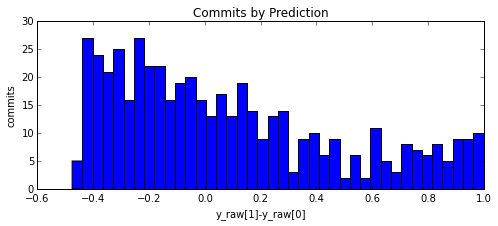

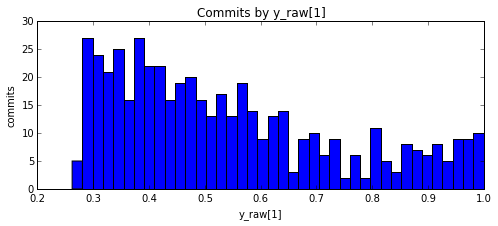

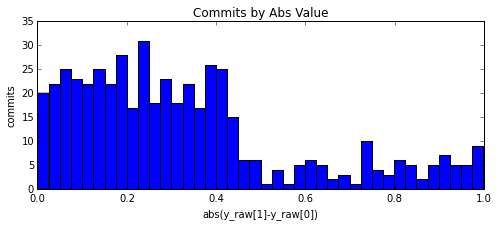

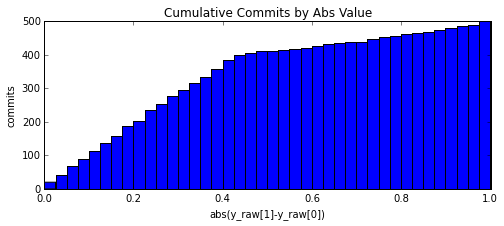

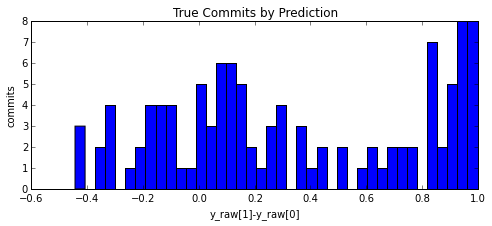

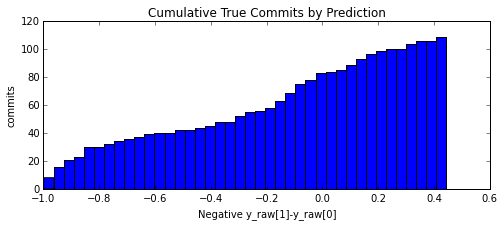

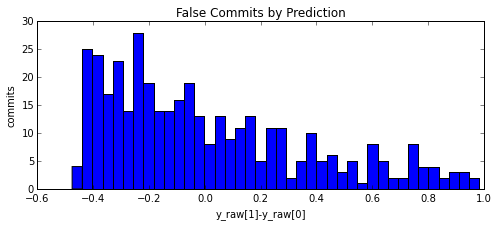

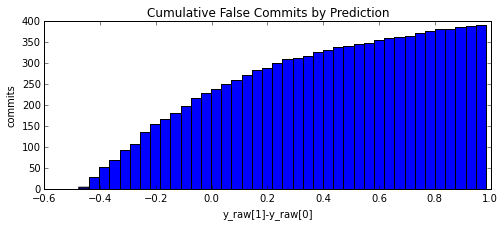

In [135]:
newShow_best(predict2, rawPredict2, X_test, Y_test, bias=0.0)

In [136]:
import sklearn
import sklearn.preprocessing